In [2]:
import pandas as pd
import numpy as np

In [108]:
data = pd.read_csv('./data/tiny_sample_data.csv')

In [3]:
data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User
0,1.498121e+12,-10.223242,-4.031835,-4.865018,-0.390958,0.456892,-0.517477,0.082608,0.579526,0.810031,-0.033991,220617,Hand,2.0,5.0,1,User1
1,1.498121e+12,-9.102754,-1.781286,-8.078036,0.342843,-1.087437,1.090648,0.175092,0.527139,0.828302,-0.073106,220617,Hand,2.0,5.0,1,User1
2,1.498121e+12,-7.067683,-3.792415,-12.239159,1.641834,-3.020055,-3.591452,0.247089,0.381125,0.852983,-0.256846,220617,Hand,2.0,5.0,1,User1
3,1.498121e+12,-8.844416,-0.181914,-11.118354,1.025997,-2.625678,-1.296871,0.430142,0.219153,0.741506,-0.465945,220617,Hand,2.0,5.0,1,User1
4,1.498121e+12,3.179461,0.718264,-9.935942,-3.889429,5.263189,1.311569,0.225644,0.255715,0.823396,-0.453160,220617,Hand,2.0,5.0,1,User1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68836,1.497460e+12,-9.368783,-2.587768,0.192931,-0.129918,0.080427,-0.304560,0.384867,-0.676317,0.228131,0.585172,140617,Torso,2.0,5.0,34,User3
68837,1.497460e+12,-8.193694,-1.666364,0.753842,-0.528795,-0.085802,0.065608,0.367071,-0.672108,0.218054,0.604961,140617,Torso,2.0,5.0,34,User3
68838,1.497460e+12,-9.632220,-1.501508,1.749135,0.109280,-0.347863,0.169926,0.389664,-0.652718,0.251713,0.598966,140617,Torso,2.0,5.0,34,User3
68839,1.497460e+12,-9.561332,-2.722536,-1.511116,-0.507558,0.180567,0.434380,0.329911,-0.694583,0.243898,0.590950,140617,Torso,2.0,5.0,34,User3


In [6]:
data.groupby(['User', 'Position'])['Segment'].count()

User   Position
User1  Bag         6190
       Hand        6191
       Hips        6190
       Torso       6190
User2  Bag         7020
       Hand        7020
       Hips        7020
       Torso       7020
User3  Bag         4000
       Hand        4000
       Hips        4000
       Torso       4000
Name: Segment, dtype: int64

In [14]:
data.query('User == "User1"').groupby('Segment')[['User']].count()

,User
Segment,
1,164
2,104
3,352
4,176
5,1792
6,1144
7,1656
8,1429
9,952


In [111]:
a = data.query('User == "User1"').groupby('Coarse_label')[['Segment']].nunique()
a['Count'] = data.query('User == "User1"').groupby('Coarse_label')['Segment'].count().values
a

,Segment,Count
Coarse_label,,
1.0,7,3444
2.0,9,2777
3.0,1,612
4.0,4,2140
5.0,3,4400
6.0,5,4172
7.0,2,3612
8.0,2,3604


# Preprocessing #1
Let's create more journeys (sub-segments) from each of the main segments using windows. From our reference paper, we're going to sample using a sliding fixed window of 2.56secs and 50% overlap

Data was downsampled to 5Hz i.e. 5 datapoints per second. Therefore our window should cover;
$$2.56~*~5 = 12$$

So the idea is to create new data for each segment for each user. 

In [56]:
# Define the window size and overlap
window_size = 12  # 2.56 seconds * 5 Hz = 12 datapoints
overlap = 0.5  # 50% overlap
step_size = int(window_size * (1 - overlap))  # Calculate the step size based on the overlap

# Path to the combined dataset
input_file = './data/tiny_sample_data.csv'
output_file = './data/sample_sub_segmented_data.csv'

# Function to create sub-segments using sliding window
def create_sub_segments(data, window_size, step_size):
      sub_segments = []
      for (user, position), user_position_data in data.groupby(['User', 'Position']):
            sub_segment_id = 1
            for segment, segment_data in user_position_data.groupby('Segment'):
                  for start in range(0, len(segment_data) - window_size + 1, step_size):
                        end = start + window_size
                        sub_segment = segment_data.iloc[start:end].copy()
                        sub_segment['Sub_Segment'] = sub_segment_id
                        sub_segments.append(sub_segment)
                        sub_segment_id += 1
      return pd.concat(sub_segments).reset_index(drop=True)

In [57]:
# # Read the entire dataset
# data = pd.read_csv(input_file)

# Create sub-segments
sub_segmented_data = create_sub_segments(data, window_size, step_size)

# Save the sub-segmented data
sub_segmented_data.to_csv(output_file, index=False, header=True)

print(f"Sub-segmented data has been saved to '{output_file}'")

Sub-segmented data has been saved to './data/sample_sub_segmented_data.csv'


In [1]:
import pandas as pd
import numpy as np

In [2]:
subbed_data = pd.read_csv('./data/sample_sub_segmented_data.csv')

In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68841 entries, 0 to 68840
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time_ms         68841 non-null  float64
 1   acceleration_x  68841 non-null  float64
 2   acceleration_y  68841 non-null  float64
 3   acceleration_z  68841 non-null  float64
 4   gyroscope_x     68841 non-null  float64
 5   gyroscope_y     68841 non-null  float64
 6   gyroscope_z     68841 non-null  float64
 7   orientation_w   68841 non-null  float64
 8   orientation_x   68841 non-null  float64
 9   orientation_y   68841 non-null  float64
 10  orientation_z   68841 non-null  float64
 11  Date            68841 non-null  int64  
 12  Position        68841 non-null  object 
 13  Coarse_label    68841 non-null  float64
 14  Fine_label      68841 non-null  float64
 15  Segment         68841 non-null  int64  
 16  User            68841 non-null  object 
dtypes: float64(13), int64(2), objec

In [5]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129984 entries, 0 to 129983
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time_ms         129984 non-null  float64
 1   acceleration_x  129984 non-null  float64
 2   acceleration_y  129984 non-null  float64
 3   acceleration_z  129984 non-null  float64
 4   gyroscope_x     129984 non-null  float64
 5   gyroscope_y     129984 non-null  float64
 6   gyroscope_z     129984 non-null  float64
 7   orientation_w   129984 non-null  float64
 8   orientation_x   129984 non-null  float64
 9   orientation_y   129984 non-null  float64
 10  orientation_z   129984 non-null  float64
 11  Date            129984 non-null  int64  
 12  Position        129984 non-null  object 
 13  Coarse_label    129984 non-null  float64
 14  Fine_label      129984 non-null  float64
 15  Segment         129984 non-null  int64  
 16  User            129984 non-null  object 
 17  Sub_Segmen

In [6]:
subbed_data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment
0,1.498121e+12,4.163218,0.040761,1.335411,3.311323,1.187522,0.901926,0.081444,0.723981,-0.193378,0.657037,220617,Bag,2.0,5.0,1,User1,1
1,1.498121e+12,15.418689,0.541218,-10.442937,1.290574,1.998349,-0.732739,0.065823,0.717362,-0.186352,0.668043,220617,Bag,2.0,5.0,1,User1,1
2,1.498121e+12,11.648319,-4.347870,-0.866619,-0.871440,-0.812067,0.218268,0.075444,0.706388,-0.237867,0.662366,220617,Bag,2.0,5.0,1,User1,1
3,1.498121e+12,7.553875,-1.145105,-0.231729,-0.262294,-0.258750,-0.212415,0.115323,0.698634,-0.272769,0.651306,220617,Bag,2.0,5.0,1,User1,1
4,1.498121e+12,11.461889,0.000774,-1.133076,0.001552,0.454414,-0.028625,0.182535,0.654054,-0.291954,0.673535,220617,Bag,2.0,5.0,1,User1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129979,1.497460e+12,-8.983045,0.037028,-0.836090,-0.227943,0.272793,0.300821,0.234563,-0.719878,0.224943,0.613312,140617,Torso,2.0,5.0,34,User3,635
129980,1.497460e+12,-9.220377,0.300305,-0.245573,-0.111315,-0.002082,0.039076,0.258752,-0.696412,0.242031,0.624078,140617,Torso,2.0,5.0,34,User3,635
129981,1.497460e+12,-10.829558,0.353513,-0.819781,0.202591,-0.274663,-0.148346,0.315893,-0.656807,0.273347,0.627769,140617,Torso,2.0,5.0,34,User3,635
129982,1.497460e+12,-9.172445,-2.381937,-0.806588,0.440924,0.027532,-0.301260,0.374337,-0.668845,0.260322,0.587151,140617,Torso,2.0,5.0,34,User3,635


### Feature Extraction for LSTM
Idea is to go through the dataset and create a feature vector like;

|$a_x$|$a_y$|$a_z$|$w_x$|$w_y$|$w_z$|$Label$|
|--|--|--|--|--|--|--|
|12 vector|12 vector|12 vector|12 vector|12 vector|12 vector|1 vector|

We already achieved the windowing as described in the paper. So what we can do is that for each subsegment, we take the 12 and it's corresponding label and then move over to the next 12.

In [60]:
a = np.arange(24*5)

start=0
window = 12
for i in range(0, int(len(a)/window), 1):
      end = start + window
      print(len(a[start:end]))
      start = end

12
12
12
12
12
12
12
12
12
12


What I want to do is to initialize a numpy array of the same shape as expected after extracting features from this dataset. Its length should be the length of the dataset divided by 12

In [89]:
start=0
window = 12

# create empty numpy array of anticipated shape
lstm_features = np.empty((int(len(subbed_data)/window), 7), dtype=object)

for i in range(0, int(len(subbed_data)/window), 1):
      end = start + window
      chunk = subbed_data.iloc[start:end, :]
      lab_list = np.unique(chunk['Coarse_label'].values)

      lstm_features[i][0] = chunk.iloc[:,1].values    # acceleration_x
      lstm_features[i][1] = chunk.iloc[:,2].values    # acceleration_y
      lstm_features[i][2] = chunk.iloc[:,3].values    # acceleration_z
      lstm_features[i][3] = chunk.iloc[:,4].values    # gyroscope_x
      lstm_features[i][4] = chunk.iloc[:,5].values    # gyroscope_y
      lstm_features[i][5] = chunk.iloc[:,6].values    # gyroscope_z
      lstm_features[i][6] = lab_list[0]   # coarse_label

      del chunk
      start = end

In [93]:
lstm_features

array([[array([ 4.163218, 15.418689, 11.648319,  7.553875, 11.461889,  4.960398,
               11.989393, 10.549128,  6.444942, 11.31465 ,  7.844662, 10.306879]),
        array([ 4.076100e-02,  5.412180e-01, -4.347870e+00, -1.145105e+00,
                7.740000e-04,  1.282470e+00, -4.675630e-01, -5.871640e+00,
                1.247329e+00,  3.249834e+00,  1.855493e+00, -2.289363e+00]),
        array([  1.335411, -10.442937,  -0.866619,  -0.231729,  -1.133076,
                -0.230472,  -2.254052,  -4.236853,   0.205752,  -0.790882,
                -1.561612,  -0.706699])                                   ,
        ...,
        array([ 1.187522,  1.998349, -0.812067, -0.25875 ,  0.454414,  1.001902,
               -0.079505, -0.738156, -0.402224,  1.293943, -0.242402, -1.11596 ]),
        array([ 0.901926, -0.732739,  0.218268, -0.212415, -0.028625,  0.671808,
                0.012586, -0.008622, -0.328888,  0.284514,  0.429266,  0.037002]),
        2.0],
       [array([11.989393, 10

In [94]:
del lstm_features

### Feature Extraction for CNN-RNN
We need to get the longitudinal acceleration, transversal acceleration and angular velocity for this data before we look to apply the 1D to 2D mapping

* What's the idea for this again? Remember that our journeys are the sub-segments

In [3]:
subbed_data.query("Position == 'Bag' & User == 'User1'").groupby('Coarse_label')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
Coarse_label,,
1.0,5,133
2.0,8,103
3.0,1,24
4.0,4,83
5.0,3,179
6.0,5,167
7.0,2,148
8.0,2,147


In [4]:
subbed_data.query("Coarse_label == 5.0").groupby('User')[['Segment','Sub_Segment']].nunique()

,Segment,Sub_Segment
User,,
User1,3,179
User2,4,279


In [13]:
subbed_data.query("Coarse_label == 5.0 & Position=='Hand'").groupby(['User','Segment'])[['Sub_Segment']].count()

Sub_Segment
User  Segment             
User1 5                876
      7                816
      9                456
User2 64              1668
      66               348
      70               660
      73               672

In [113]:
a = pd.read_csv('./data/train_data_User3.csv')

In [116]:
a['Coarse_label'].value_counts()

7.0    246300
1.0    183898
2.0    159313
4.0     51904
Name: Coarse_label, dtype: int64

In [117]:
del a, data

It seems like User 3 has no driving data. This looks like it might present a problem. I'll have to download an additional dataset an add to this. For now, ignore this as this User 3 driving won't be predicted. Seeing as the additional data is a mixture of User2 and User3, it can be added in as unsupervised learning if time permits. For now, kindly forge ahead and let Johan know. http://www.shl-dataset.org/activity-recognition-challenge-2020/

Problem can be binary for now i.e. the CNN and RNN part. LSTM doesn't really care if its missing as it doesn't take driver detail into consideration.

To continue with the feature extractor for this CNN-GRU part, we need to get the longitudinal and transversal acceleration from the $acc_x$, $acc_y$, and $acc_z$. To get that, I'll need to get the rotation matrix for every subsection??

* My next question/confusion was related to how journeys are understood for this task. Given that this is a multi-task problem, I would want to retain the fact that the journeys are split this way. I mean, the purpose of research is to try out new things. Failure is also a good result. 
* As a result the plan is to transform the sub-segment journeys to long acc, tranv acc and ang vel and then convert those to 2D. No need for windows seeing as these subjourneys were already windowed. You get?


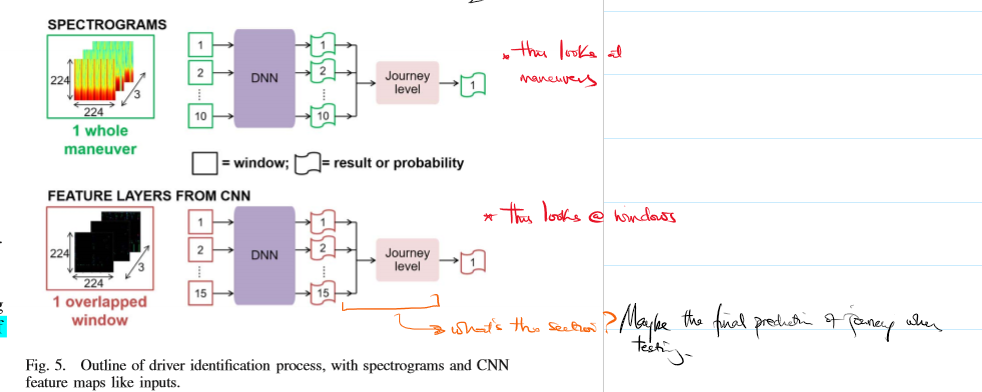

#### Getting the Euler's angles from the Quaternions

$$\varphi=\arctan{\left( \frac{2(q_1q_0+q_2q_3)}{q_0^2-q_1^2-q_2^2+q_3^2} \right)}$$

$$ \theta=-\arcsin(2(q_1q_3-q_2q_0))$$

$$\psi=\arctan{\left( \frac{2(q_3q_0+q_1q_2)}{q_0^2+q_1^2-q_2^2-q_3^2} \right)}$$



In [3]:
def euler_from_quaternions(q):
      '''
      Gets the Euler angles (roll, pitch and yaw) from quaternions using (ZYX notation)
      Input:
         q: Array which contains orientation coordinates w, x, y, z which corresponds to (q0, q1, q2, q3)
      Output:
         roll, pitch, and yaw in degrees
      '''
      q0, q1, q2, q3 = q

      # Roll (x-axis rotation)
      roll = np.arctan2(2 * (q1 * q0 + q2 * q3), q0**2 - q1**2 - q2**2 + q3**2)

      # Pitch (y-axis rotation)
      pitch = -np.arcsin(2 * (q1 * q3 - q2 * q0))

      # Yaw (z-axis rotation)
      yaw = np.arctan2(2 * (q3 * q0 + q1 * q2), q0**2 + q1**2 - q2**2 - q3**2)

      return np.degrees(roll), np.degrees(pitch), np.degrees(yaw)


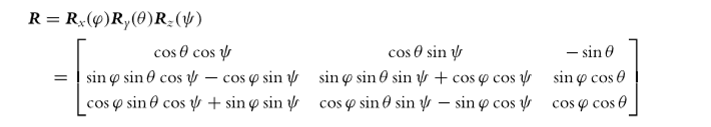

In [4]:
def get_rot_from_euler(sub_segment):
      roll_pitch_yaw_df = sub_segment.apply(euler_from_quaternions, axis=1, result_type='expand')
      roll, pitch, yaw = roll_pitch_yaw_df.median()
      
      # rotation matrix
      R = np.array([
                  [(np.cos(pitch)* np.cos(yaw)), (np.cos(pitch) * np.sin(yaw)), -np.sin(pitch)],
                  [((np.sin(roll)*np.sin(pitch)*np.cos(yaw)) - (np.cos(roll)*np.sin(yaw))), ((np.sin(roll)*np.sin(pitch)*np.sin(yaw)) + (np.cos(roll) * np.cos(yaw))), (np.sin(roll) * np.cos(pitch))],
                  [((np.cos(roll)*np.sin(pitch)*np.cos(yaw)) + (np.sin(roll)*np.sin(yaw))), ((np.cos(roll)*np.sin(pitch)*np.sin(yaw)) - (np.sin(roll) * np.cos(yaw))), (np.cos(roll) * np.cos(pitch))]
                  ])

      return R

Let's try out the other method;

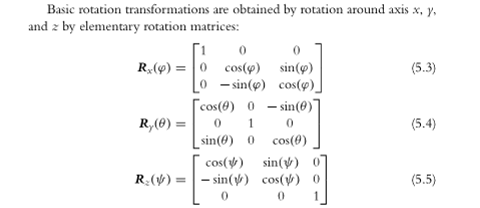

In [5]:
def get_rot_from_euler2(sub_segment):
      roll_pitch_yaw_df = sub_segment.apply(euler_from_quaternions, axis=1, result_type='expand')
      roll, pitch, yaw = roll_pitch_yaw_df.median()
      
      # rotation matrix
      Rx = np.array([
                    [1, 0, 0],
                    [0, np.cos(roll), np.sin(roll)],
                    [0, -np.sin(roll), np.cos(roll)]
                    ])
      Ry = np.array([
                    [np.cos(pitch), 0, -np.sin(pitch)],
                    [0, 1, 0],
                    [np.sin(pitch), 1, np.cos(pitch)]
                    ])
      Rz = np.array([
                    [np.cos(yaw), np.sin(yaw), 0],
                    [-np.sin(yaw), np.cos(yaw), 0],
                    [0, 0, 1]
                    ])
      
      R = Rx @ Ry @ Rz

      return R

There's actually no need to convert this to Euler angles instead we can just get the Rotation Matrix (ZYX) from it

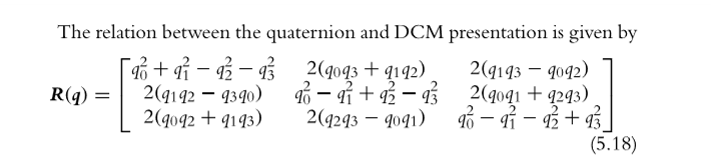

This means, you'll have to take the median of the quartenions for each subsegment and apply the rotation matrix to rotate that.

In [6]:
def quaternion_to_rotation_matrix_zyx(q):
      '''
      Get rotation matrix (ZYX notation) from quaternion
      Input:
         q: Array which contains orientation coordinates w, x, y, z which corresponds to (q0, q1, q2, q3)
      Output:
         rotation matrix (ZYX notation), numpy array
      '''
      q0, q1, q2, q3 = q

      # rotation matrix
      R = np.array([
                  [(q0**2 + q1**2 - q2**2 - q3**2), 2*(q0*q3 + q1*q2), 2*(q1*q3 - q0*q2)],
                  [2*(q1*q2 - q3*q0), (q0**2 - q1**2 + q2**2 - q3**2), 2*(q0*q1 + q2*q3)],
                  [2*(q0*q2 + q1*q3), 2*(q2*q3 - q0*q1), (q0**2 - q1**2 - q2**2 + q3**2)]
                  ])

      return R

def get_rotation_matrix_sub_segment(sub_segment):
      '''
      For each sub_segment or sub_journey, we estimate the median quaternion and use it to create our rotation matrix
      Input:
            sub_segment: Array containing orientation coordinates w, x, y, z for sub_segment. Expected shape
                         is (len(sub_segment), 4)
      Output:
            rotation matrix (ZYX notation). numpy array
      '''
      q = sub_segment.median()

      R = quaternion_to_rotation_matrix_zyx(q)

      return R
      

**You know, for now, we'll have to stick with using the Euler angles to derive our rotation matrix because I don't think getting using the median of the quaternion and the median of the Euler angles will result in the same rotation matrix. As a result, this might cause some problems. For now, we stick with euler angles**

In [18]:
get_rotation_matrix_sub_segment(subbed_data.query("User == 'User1' & Sub_Segment == 635 & Position == 'Hand'").iloc[:,7:11])

array([[-0.05261799,  0.89011568, -0.43066735],
       [-0.06237121, -0.43340547, -0.88815453],
       [-0.98685872, -0.02006779,  0.07909553]])

In [19]:
get_rot_from_euler(subbed_data.query("User == 'User1' & Sub_Segment == 635 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.08470237, -0.97593975,  0.20091568],
       [-0.92971683, -0.14993885, -0.33637028],
       [ 0.35840219, -0.15830332, -0.92004779]])

In [20]:
get_rot_from_euler2(subbed_data.query("User == 'User1' & Sub_Segment == 635 & Position == 'Hand'").iloc[:,7:11])

array([[ 0.08470237, -0.97593975,  0.20091568],
       [-1.27180298, -0.1796287 , -0.33637028],
       [-0.57727979, -0.2395117 , -0.92004779]])

Slightly different values but later on, I'll check to see why

-----------

* For each sub_segment,
   - get the rotation matrix
   - apply to sub_segment and get long acc and transv acc
   - get the magnitude of the gyro measurements --> angular velocity

In [21]:
subbed_data

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,orientation_z,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment
0,1.498121e+12,4.163218,0.040761,1.335411,3.311323,1.187522,0.901926,0.081444,0.723981,-0.193378,0.657037,220617,Bag,2.0,5.0,1,User1,1
1,1.498121e+12,15.418689,0.541218,-10.442937,1.290574,1.998349,-0.732739,0.065823,0.717362,-0.186352,0.668043,220617,Bag,2.0,5.0,1,User1,1
2,1.498121e+12,11.648319,-4.347870,-0.866619,-0.871440,-0.812067,0.218268,0.075444,0.706388,-0.237867,0.662366,220617,Bag,2.0,5.0,1,User1,1
3,1.498121e+12,7.553875,-1.145105,-0.231729,-0.262294,-0.258750,-0.212415,0.115323,0.698634,-0.272769,0.651306,220617,Bag,2.0,5.0,1,User1,1
4,1.498121e+12,11.461889,0.000774,-1.133076,0.001552,0.454414,-0.028625,0.182535,0.654054,-0.291954,0.673535,220617,Bag,2.0,5.0,1,User1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129979,1.497460e+12,-8.983045,0.037028,-0.836090,-0.227943,0.272793,0.300821,0.234563,-0.719878,0.224943,0.613312,140617,Torso,2.0,5.0,34,User3,635
129980,1.497460e+12,-9.220377,0.300305,-0.245573,-0.111315,-0.002082,0.039076,0.258752,-0.696412,0.242031,0.624078,140617,Torso,2.0,5.0,34,User3,635
129981,1.497460e+12,-10.829558,0.353513,-0.819781,0.202591,-0.274663,-0.148346,0.315893,-0.656807,0.273347,0.627769,140617,Torso,2.0,5.0,34,User3,635
129982,1.497460e+12,-9.172445,-2.381937,-0.806588,0.440924,0.027532,-0.301260,0.374337,-0.668845,0.260322,0.587151,140617,Torso,2.0,5.0,34,User3,635


In [36]:
position = 'Hand'
user = 'User1'
len(subbed_data.query('Coarse_label == 5.0'))/12

1832.0

In [104]:
subbed_data.groupby(['User', 'Position', 'Sub_Segment']).count()['Coarse_label'].unique()

array([12], dtype=int64)

I was thinking of looping through each user, position, segment and then sub-segment but that's not efficient. I already know that each subsegment has 12 data points, why don't I just look at 12 data points like I did in the LSTM section? 

In [7]:
# add long_acc, tranv_acc and ang_vel to columns
def add_transf_cols(data):
      data['long_acc'] = np.nan
      data['tranv_acc'] = np.nan
      data['ang_vel'] = np.nan

      return data

In [8]:
subbed_data = add_transf_cols(subbed_data)

In [9]:
def rotate_acc_to_global_coord(data, window=None):
      '''
      Takes the dataset (where coarse_label == 5.0) and for each sub_segment, it get's the rotation matrix 
      (using the orientation sensor data), to rotate the accelerometer triaxal data to the global coordinates.
      Input:
            data: dataframe with appropriate labels
            window: the number of datapoints in each sub-segment
      Output:
            dataframe with appended columns (longitudinal acceleration, transversal acceleration corresponding to a'_x, a'_y)
      '''
      if window is None:
            window = data.groupby(['User', 'Position', 'Sub_Segment']).count()['Coarse_label'].unique()[0]

      # get idx of columns in df
      cols = ['acceleration_x', 'acceleration_y', 'acceleration_z',
              'orientation_w', 'orientation_x', 'orientation_y', 'orientation_z']
      col_idx = [data.columns.get_loc(col) for col in cols]

      start = 0
      for i in range(0, int(len(data)/window), 1):
            end = start + window
            chunk = data.iloc[start:end, col_idx].copy() # gives me the needed columns

            # get rotation matrix and rotate acc vals to global coord
            R = get_rot_from_euler(chunk.iloc[:,3:]) # sends in only the orientation data and results in rotation matrix
            long_acc, tranv_acc = (chunk.iloc[:,:3] @ R)[0], (chunk.iloc[:,:3] @ R)[1]

            # attach values to df
            repl_idx_long = data.columns.get_loc('long_acc')
            repl_idx_tranv = data.columns.get_loc('tranv_acc')
            data.iloc[start:end, repl_idx_long] = long_acc
            data.iloc[start:end, repl_idx_tranv] = tranv_acc

            del chunk, long_acc, tranv_acc
            start = end

      return data

def get_angular_vel_from_gyr(data):
      '''
      Takes the dataset (where coarse_label == 5.0) and get's the angular velocity which corresponds to the square root of the sum of the
      squared gyroscope measurements
      Input:
            dataframe with appropriate labels
      Output:
            dataframe with appended columns (ang_vel)
      '''
      # get idx of columns in df
      cols = ['gyroscope_x', 'gyroscope_y', 'gyroscope_z']
      #col_idx = [data.columns.get_loc(col) for col in cols]
      
      # simply the sqrt of the sum of the squared gyro measurements
      ang_vel = np.sqrt(np.sum(data[cols]**2, axis=1))
      data['ang_vel'] = ang_vel

      return data

In [10]:
def get_long_tranv_angl(data):
      '''Gets the longitudinal acc, tranversal acc and angular velocity for coarse label == 5.0'''
      idx = data.query('Coarse_label == 5.0').index

      modified_data = get_angular_vel_from_gyr(rotate_acc_to_global_coord(data.loc[idx, :]))
      data.loc[idx, :] = modified_data

      return data

In [11]:
subbed_data = get_long_tranv_angl(subbed_data)

In [12]:
subbed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129984 entries, 0 to 129983
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   time_ms         129984 non-null  float64
 1   acceleration_x  129984 non-null  float64
 2   acceleration_y  129984 non-null  float64
 3   acceleration_z  129984 non-null  float64
 4   gyroscope_x     129984 non-null  float64
 5   gyroscope_y     129984 non-null  float64
 6   gyroscope_z     129984 non-null  float64
 7   orientation_w   129984 non-null  float64
 8   orientation_x   129984 non-null  float64
 9   orientation_y   129984 non-null  float64
 10  orientation_z   129984 non-null  float64
 11  Date            129984 non-null  int64  
 12  Position        129984 non-null  object 
 13  Coarse_label    129984 non-null  float64
 14  Fine_label      129984 non-null  float64
 15  Segment         129984 non-null  int64  
 16  User            129984 non-null  object 
 17  Sub_Segmen

In [168]:
subbed_data#.query('Coarse_label == 5.0')

,time_ms,acceleration_x,acceleration_y,acceleration_z,gyroscope_x,gyroscope_y,gyroscope_z,orientation_w,orientation_x,orientation_y,...,Date,Position,Coarse_label,Fine_label,Segment,User,Sub_Segment,long_acc,tranv_acc,ang_vel
0,1.498121e+12,4.163218,0.040761,1.335411,3.311323,1.187522,0.901926,0.081444,0.723981,-0.193378,...,220617,Bag,2.0,5.0,1,User1,1,NaN,NaN,NaN
1,1.498121e+12,15.418689,0.541218,-10.442937,1.290574,1.998349,-0.732739,0.065823,0.717362,-0.186352,...,220617,Bag,2.0,5.0,1,User1,1,NaN,NaN,NaN
2,1.498121e+12,11.648319,-4.347870,-0.866619,-0.871440,-0.812067,0.218268,0.075444,0.706388,-0.237867,...,220617,Bag,2.0,5.0,1,User1,1,NaN,NaN,NaN
3,1.498121e+12,7.553875,-1.145105,-0.231729,-0.262294,-0.258750,-0.212415,0.115323,0.698634,-0.272769,...,220617,Bag,2.0,5.0,1,User1,1,NaN,NaN,NaN
4,1.498121e+12,11.461889,0.000774,-1.133076,0.001552,0.454414,-0.028625,0.182535,0.654054,-0.291954,...,220617,Bag,2.0,5.0,1,User1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129979,1.497460e+12,-8.983045,0.037028,-0.836090,-0.227943,0.272793,0.300821,0.234563,-0.719878,0.224943,...,140617,Torso,2.0,5.0,34,User3,635,NaN,NaN,NaN
129980,1.497460e+12,-9.220377,0.300305,-0.245573,-0.111315,-0.002082,0.039076,0.258752,-0.696412,0.242031,...,140617,Torso,2.0,5.0,34,User3,635,NaN,NaN,NaN
129981,1.497460e+12,-10.829558,0.353513,-0.819781,0.202591,-0.274663,-0.148346,0.315893,-0.656807,0.273347,...,140617,Torso,2.0,5.0,34,User3,635,NaN,NaN,NaN
129982,1.497460e+12,-9.172445,-2.381937,-0.806588,0.440924,0.027532,-0.301260,0.374337,-0.668845,0.260322,...,140617,Torso,2.0,5.0,34,User3,635,NaN,NaN,NaN


#### Training the Simple CNN for feature extraction
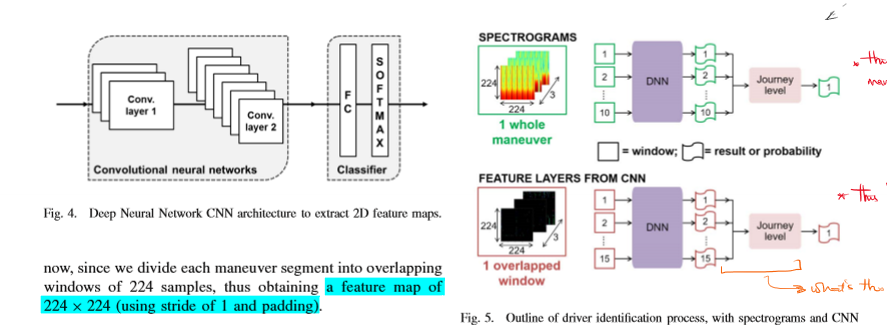

Get only the records associated with driving

In [13]:
subbed_data_Driver = subbed_data.query('Coarse_label == 5.0').copy()
subbed_data_Driver = subbed_data_Driver.reset_index(drop=True)

Since I would need to pass 224 long vector in and the sub-segments are of length 12, I'll need to join them together. 

**This code might change when I decide to work with a segment that has lotss of data. Will the 224 cover it?**

In [14]:
def combine_sequences(subbed_data_Driver):
      combined_sequences = {}
      users = subbed_data_Driver['User'].unique()

      for user in users:
            user_data = subbed_data_Driver.query("User == @user")
            segments = user_data['Segment'].unique()
            for segment in segments:
                  segment_data = user_data.query("Segment == @segment")
                  long_acc = segment_data['long_acc'].values
                  tranv_acc = segment_data['tranv_acc'].values
                  ang_vel = segment_data['ang_vel'].values
                  combined_sequences[(user, segment)] = {   
                        'long_acc': long_acc,
                        'tranv_acc': tranv_acc,
                        'ang_vel': ang_vel
                        }
      
      return combined_sequences

Create 224-sized windows

When it comes to this window of a thing, I believe it's taking in the split journeys and trying to predict who it is. That way, it learns a pattern and we extract that as our feature map.

In [15]:
def create_windows(data, window_size, overlap):
      stride = int(window_size * (1 - overlap))
      num_windows = (len(data) - window_size) // stride + 1
      windows = np.array([data[i*stride:i*stride+window_size] for i in range(num_windows)])
      return windows

In [16]:
def get_windowed_df(subbed_data_Driver, window_size=224, overlap=0.25):
      windowed_data = []
      combined_sequences = combine_sequences(subbed_data_Driver)

      for (user, segment), signals in combined_sequences.items():
            long_windows = create_windows(signals['long_acc'], window_size, overlap)
            tranv_windows = create_windows(signals['tranv_acc'], window_size, overlap)
            ang_vel_windows = create_windows(signals['ang_vel'], window_size, overlap)

            for i in range(long_windows.shape[0]):
                  windowed_data.append({
                        'user': user,
                        'segment': segment,
                        'window_index': i,
                        'long_acc_window': long_windows[i],
                        'tranv_acc_window': tranv_windows[i],
                        'ang_vel_window': ang_vel_windows[i]
                  })

      return pd.DataFrame(windowed_data)

In [17]:
windowed_df = get_windowed_df(subbed_data_Driver)

In [18]:
windowed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user              125 non-null    object
 1   segment           125 non-null    int64 
 2   window_index      125 non-null    int64 
 3   long_acc_window   125 non-null    object
 4   tranv_acc_window  125 non-null    object
 5   ang_vel_window    125 non-null    object
dtypes: int64(2), object(4)
memory usage: 6.0+ KB


In [19]:
(windowed_df)

,user,segment,window_index,long_acc_window,tranv_acc_window,ang_vel_window
0,User1,5,0,"[-9.758601092653436, -9.531220058208657, -9.18...","[1.2163871551959011, 1.3361298184936203, 1.566...","[0.0648405923554065, 0.052195043538634966, 0.0..."
1,User1,5,1,"[5.393793875687761, 5.462767172477192, 5.42716...","[-2.369580811231706, -3.1419008781515183, -2.2...","[0.08666588323556162, 0.06540562007197852, 0.0..."
2,User1,5,2,"[-3.0848349238025863, -3.061933773164546, -3.0...","[-9.127916005262007, -8.872422354776937, -9.04...","[0.010446414217328354, 0.00546182020941737, 0...."
3,User1,5,3,"[-3.6407021896953493, -3.7521261067104197, -3....","[-8.663937850350159, -8.974538766953652, -8.66...","[0.008970671156608072, 0.0042361173260428, 0.0..."
4,User1,5,4,"[-4.667905068376334, -4.670088210768102, -4.53...","[-8.225614194256705, -8.297913190531586, -8.23...","[0.0037716724407084986, 0.005322355681462861, ..."
...,...,...,...,...,...,...
120,User2,73,10,"[-1.384294227421536, -0.9944340407900003, -1.0...","[-8.775445893248676, -9.278713875143422, -8.76...","[0.056651497941360734, 0.033085182257318754, 0..."
121,User2,73,11,"[6.9331308565209495, 6.76483662873617, 6.88341...","[6.083043662460269, 6.011583604598315, 5.94784...","[0.030063213018571386, 0.08617717004520396, 0...."
122,User2,73,12,"[8.770749371132043, 9.277007625632198, 9.10655...","[-3.708785415869371, -3.6977317188448486, -4.1...","[0.561711412735223, 0.19096256199841893, 0.305..."
123,User2,73,13,"[8.395964169227076, 8.236395878834838, 8.48513...","[3.1940509427803927, 2.9159576809066365, 3.075...","[0.047081548933738365, 0.13333614808820599, 0...."


Prepare the input for CNN

In [37]:
def prep_input_for_CNN(windowed_df):
      X = []
      y = []

      for index, row in windowed_df.iterrows():
            long_acc_window = row['long_acc_window']
            tranv_acc_window = row['tranv_acc_window']
            ang_vel_window = row['ang_vel_window']
            combined_window = np.stack([long_acc_window, tranv_acc_window, ang_vel_window], axis=1)
            X.append(combined_window)
            y.append(row['user'])

      X = np.array(X)
      y_lab = np.array(y)
      _, y = np.unique(y_lab, return_inverse=True)
      return X, y

In [38]:
X, y = prep_input_for_CNN(windowed_df)

I have a few questions and just because I bring them to your attention doesn't mean I'm correct.

i. Given that this data is temporal, does splitting it via a shuffle or using dataloader and a shuffle affect it. Keep in mind how we got X and y when you answer this.

ii. How can I visualize the feature maps

Next use CNN this to train CNN

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split

In [99]:
# X.shape = (num_samples, 224, 3)
# y.shape = (num_samples, )
print(X.shape)
print(y.shape)

(125, 224, 3)
(125,)


Simple CNN model

In [88]:
# Define the CNN model
class CNNModel(nn.Module):
      def __init__(self, num_classes):
            super(CNNModel, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=3, out_channels=224, 
                                   kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm1d(224) ##
            self.conv2 = nn.Conv1d(in_channels=224, out_channels=224, 
                                   kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm1d(224)  ##
            self.dropout = nn.Dropout(p=0.5) ##
            self.fc1 = nn.Linear(224 * 224, 128)
            self.fc2 = nn.Linear(128, num_classes)
            self.softmax = nn.Softmax(dim=1)
            
      def forward(self, x):
            x = self.conv1(x)
            x = self.bn1(x) ##
            x = nn.ReLU()(x)
            
            x = self.conv2(x)
            feature_map = self.bn2(x)
            feature_map = nn.ReLU()(x)
            
            x = feature_map.view(x.size(0), -1)  # Flatten the output of the conv layers
            x = self.dropout(x) ##
            x = self.fc1(x)
            x = nn.ReLU()(x)
            x = self.fc2(x)
            x = self.softmax(x)
            
            return x, feature_map

In [90]:
# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, 
                                                    random_state=123, stratify=y_tensor)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [96]:
# Initialize model, loss function, and optimizer
num_classes = len(torch.unique(y_tensor))
model = CNNModel(num_classes=num_classes).cuda()  # Move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0 ##
      for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()  # Move data to GPU
            optimizer.zero_grad()
            outputs, _ = model(batch_X.transpose(1, 2))  # Transpose to match (batch_size, in_channels, seq_length)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0) ##

      epoch_loss = running_loss / len(train_loader.dataset) ##
      print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}') ##
      #print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Testing the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
      for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.cuda(), batch_y.cuda()  # Move data to GPU
            outputs, _ = model(batch_X.transpose(1, 2))
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
      print(f'Accuracy: {100 * correct / total}%')

Epoch 1/20, Loss: 0.7052
Epoch 2/20, Loss: 0.7033
Epoch 3/20, Loss: 0.7033
Epoch 4/20, Loss: 0.7033
Epoch 5/20, Loss: 0.7033
Epoch 6/20, Loss: 0.7033
Epoch 7/20, Loss: 0.7033
Epoch 8/20, Loss: 0.7033
Epoch 9/20, Loss: 0.7033
Epoch 10/20, Loss: 0.7033
Epoch 11/20, Loss: 0.7033
Epoch 12/20, Loss: 0.7033
Epoch 13/20, Loss: 0.7033
Epoch 14/20, Loss: 0.7033
Epoch 15/20, Loss: 0.7033
Epoch 16/20, Loss: 0.7033
Epoch 17/20, Loss: 0.7033
Epoch 18/20, Loss: 0.7033
Epoch 19/20, Loss: 0.7033
Epoch 20/20, Loss: 0.7033
Accuracy: 60.0%


In [109]:
# Extract feature maps from the intermediate layer
feature_maps = []
model.eval()
i = 0
with torch.no_grad():
      for batch_X, _ in test_loader:
            batch_X = batch_X.cuda()  # Move data to GPU
            _, feature_map = model(batch_X.transpose(1, 2))
            feature_maps.append(feature_map.cpu().numpy())  # Move feature maps to CPU

# Flatten the list of feature maps
feature_maps = np.concatenate(feature_maps, axis=0)
print(f'Feature maps shape: {feature_maps.shape}')

Feature maps shape: (25, 224, 224)


<font color='yellow'>The issue here was that you wanted to see something like;


``` torch.Size[25, 3, 224, 224]```

Where 25 represents the number of test samples, 3 represents the channels long, transv and ang_vel and 224x244 shows the shape of each image.</font>